# Lesson 1: Introduction and Simple Morphing with Two Parameters

In order to get to grips with the [RooLagrangeMorphFunc](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc), this steps through a simplistic code example that aims to demonstrate the usage of the tool.

In [1]:
#include "RooStringVar.h"
#include "RooLagrangianMorphFunc.h"


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



now set root version to special HComb build

[RooLagrangeMorphFunc](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc) is a standalone RooFit class implementing the analytical morphing method, descibed in [ATL-PHYS-PUB-2015-047](https://cds.cern.ch/record/2066980). Analytical morphing is a method to construct a continuous signal model in the coupling parameter space. Basic assumption is that shape and cross section of a physical distribution is proportional to its squared matrix element. The signal model is constructed by a weighted sum over $N$ input distributions of an observable $T$. The calculation of the weights is based on Matrix Elements evaluated for the different input scenarios.

The number of input files depends on the number of couplings in production and decay vertices, and also whether the decay and production vertices describe the same process or not.

The implementation of [RooLagrangeMorphFunc](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc) is based on the Higgs Characterisation Model [arxiv:1306.6464](https://arxiv.org/abs/1306.6464) implemented in [MadGraph5 _MC@NLO](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/MadGraph5aMCatNLOForAtlas). It is possible to add another theoretical framework, if such a use case arises, please contact the developers.

## Morphing principles

The morphing procedure is based on the concepts of the morphing of (possibly multi-dimensional) histograms described [here](https://arxiv.org/abs/1410.7388). It is introduced to describe the dependence of a given physical observable
$T$ on an arbitrary configuration of a set of non-SM Higgs boson couplings $\vec{g}_\mathrm{target} \equiv \{g_\mathrm{SM},g_\mathrm{BSM,1},g_\mathrm{BSM,n}\}$ to known particles. This dependence is described by a morphing function
$$T_\mathrm{out}(\vec{g_\mathrm{target}})=\sum_i w_i(\vec{g_\mathrm{target}};\vec{g_i})T_\mathrm{in}(\vec{g_i})$$
which linearly combines the values or differential distributions $T$ in at a number of selected discrete coupling
configurations $\vec{g}_i = \{g_\mathrm{SM,i},g_\mathrm{BSM,i}\}$. The input distributions $T_\mathrm{in}$ are normalised to their expected cross sections such that $T_\mathrm{out}$ includes not only the correct shape, but also the correct cross section prediction. Here, $g_\mathrm{SM}$ denotes the Higgs boson coupling predicted by the Standard Model. Morphing only requires that any differential cross section can be expressed as a polynomial in coupling parameters. For calculation at lowest order and using the narrow-width approximation for a resonance, this yields a second order polynomial each in production and decay.

n practice, the template distributions $T_\mathrm{in}$ are obtained from the Monte Carlo (MC) simulation of the signal process for a given coupling configuration $\vec{g_i}$. The minimal number $N$ of Monte Carlo samples needed to describe the signal at all possible coupling configurations, depends on the number $n$ of studied non-SM coupling parameters. The contribution of each sample $T_\mathrm{in}$ is weighted by a weight $w_i$ based on the assumption that the value of a physical observable is proportional to the squared matrix element for the studied process
$$T\propto\mathcal{M}^2$$

The weights $w_i$ can therefore be expressed as functions of the coupling parameters in the matrix element $\mathcal{M}$. In this case $T$ can be anything derived from the Matrix element, for example a whole MC sample.

The described procedure allows for a continuous description in an $n$-dimensional parameter space. A feature-complete implementation has been developed within the [RooFit package](https://cds.cern.ch/record/2066980/files/physics/0306116), making use of [HistFactory](https://cds.cern.ch/record/1456844). The provided signal model can therefore be used in commonly used RooFit workspaces in a straightforward, blackbox-like way.

## Define input files and samples

The histograms we will use as an input are located in a ROOT file. The name of that file is stored in the variable called "infilename". Since that file contains multiple histograms, the exact histogram we will be using is identified by the variable "observable". You can open the input file and explore it's hierarchy to use a different input distribution if you like to! 

As input, the RooEFTMorphFunc expects a single ROOT file of the following layout: 

![like this](https://twiki.cern.ch/twiki/pub/AtlasProtected/RooEFTMorphFunc/folderstructure.png "if it doesn't look like this you're doing it wrong")

Here, the first hierarchy level is comprised by the different input samples, whereas the second hierarchy level can have arbitrary meaning - for example, different event selections applied. Inside these folders, the physical inputs - distributios of type TH1 - should reside. Other input types are planned to be implemented, but for now, we only support types derived from TH1.

Each top-level folder additionally contains another histogram of type TH1 with the name "param_card". This is used to encode the parameter setup which was used to produce this sample. These histograms should have labeled bins and might look like this: 

![With this](https://twiki.cern.ch/twiki/pub/AtlasProtected/RooEFTMorphFunc/param_hist.png "Get yerself a wiggle at them kappas")

The layout of the subfolders has to be the same for all samples, meaning that every sub-level folder has to contain the exact same number of subfolders with the same names, each containing the exact same number of histograms with the same names. 

## Number of input samples

The number of inputsamples needed for successful morphing depends on

* the process
* the couplings included in the process 

In some cases, the morphing class is returning warnings when the input is not reasonable. But at the moment it does not catch all possible problems and the user should make sure that her/his input is reasonable to ensure successful morphing. 

## Get Example File and Samples

The available identifiers in this case are: ggfZZ, ggfWW, vbfWW, vbfZZ, ggfZZ, and vbfMuMu. Let's get some!

Here we use the histogram name "base/phi" to identify the observable to be used

In [2]:
std::string identifier("ggfZZ");
std::string infilename("/eos/user/v/vcroft/morphingInputs/ggfhzz4l_2d.root");
std::string observable("base/phi");

Since the input file contains input from a lot of different samples, we need to tell the [RooLagrangeMorphFunc](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc) which ones to use as a basis for the morphing. This is done by pushing their names into a list. 

In [3]:
std::vector<std::string> samplelist = {"s1","s2","s3"};

This list is not enough, it need to be RooFit compatible. Push all the input samples in a RooArgList

In [4]:
RooArgList inputs;

we need the additional list "inputnames" to prevent the python garbage collector from deleting the RooStringVars

In [5]:
for(auto const& sample: samplelist) {
    RooStringVar* v = new RooStringVar(sample.c_str(),sample.c_str(),sample.c_str());
    inputs.add(*v);
}

## setup predefined morphing function

With the name of the input file and the list of input sample names, we can call the constructor of the RooEFTMorphFunc to obtain an instance. Since the input we are using is a sample of ggF Higgs production with decay to two Z bosons, we are using the corresponding variant of the RooLagrangeMorphFunc called "RooHCggfZZMorphFunc". 

You will later learn how to create your own variants of this class for different physical processes. The identifier handed to the constructor is just a name that will help you identify the object when you store it in a workspace, which will you will be doing shortly. 

In [6]:
RooLagrangianMorphFunc* morphfunc = new RooHCggfZZMorphFunc(identifier.c_str(),identifier.c_str(),infilename.c_str(),observable.c_str(),inputs);

RooLagrangianMorphFunc: a RooFit class for morphing physics distributions between configurations. authors:
   Lydia Brenner   (lbrenner@cern.ch)
   Carsten Burgard (cburgard@cern.ch)
   Katharina Ecker (kecker@cern.ch)
   Adam Kaluza     (akaluza@cern.ch)
please feel free to contact with questions and suggestions.


morph to the validation sample v1! ![it's morphin time](http://images6.fanpop.com/image/photos/38800000/-It-s-Morphin-Time-friends-38813578-500-250.gif "You must do this action or the function won't work")

First we set the parameters of the function to point to the desired sample. Then we create a histogram of the target variable at that point.

In [7]:
std::string validationsample("v1");
morphfunc->setParameters(validationsample.c_str());
TH1* morphing = morphfunc->createTH1("morphing");

## Read The Validation Histogram

We want to know how close to the desired distribution the morphed distribution is. Let's open the input file to get the validation histogram for comparison.

We deliberately set the parameters to one of the validation samples that are available in the same input file. Conveniently, the input format used by the (RooLagrangeMorphFunc)[https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc] also contains all the parameters, such that we only need to call the method "setParameters" with the name of a sample as an argument to use its parameter settings. 

Previously we used the "createTH1" method in (RooLagrangeMorphFunc)[https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc] to create a histogram with the morphed distribution predicted at the given parameters by the (RooLagrangeMorphFunc)[https://twiki.cern.ch/twiki/bin/view/AtlasProtected/RooEFTMorphFunc]. The argument given to the method is just an arbitrary object name. 

In order to have something to compare to, we now retrieve the corresponding histogram of the validation sample from the same input file. 

In [8]:
TFile* file = TFile::Open(infilename.c_str(),"READ");
TFolder* folder = 0;
file->GetObject(validationsample.c_str(),folder);
TH1* validation = dynamic_cast<TH1*>(folder->FindObject(observable.c_str()));
validation->SetDirectory(NULL);
validation->SetTitle(validationsample.c_str());
file->Close();

## Results!

we use the canvas created above and add legend in order to plot both histograms - the one obtained from the validation sample and the morphing prediction for the same parameter set - for comparison.

Here I use the rootnotes macro to provide inline plots. On newer releases this isn't necesarry, but then the Function isn't available... 

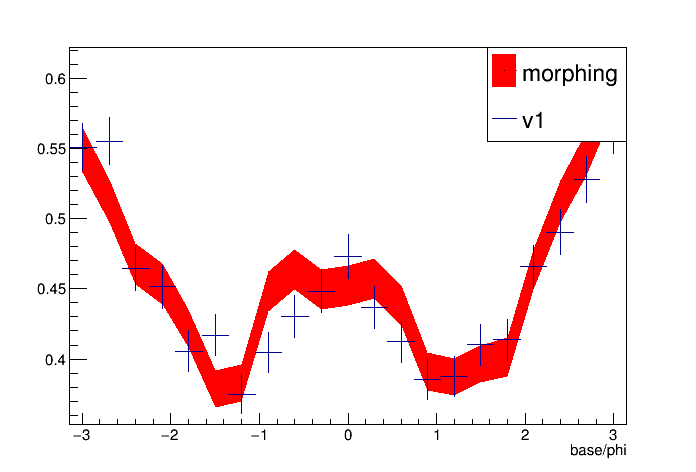

In [9]:
TCanvas plot;
gStyle->SetOptStat(0);
gStyle->SetOptTitle(0);
morphing->GetXaxis()->SetTitle(observable.c_str());
morphing->SetLineColor(kRed);
morphing->SetFillColor(kRed);
morphing->Draw("E3");
validation->Draw("SAME");
TLegend* leg = new TLegend(0.7,0.7,0.9,0.9);
leg->AddEntry(morphing);
leg->AddEntry(validation);
leg->Draw();
plot.Draw();

## Playground 

In this naming scheme, we clearly differentiate between input samples ("s1","s2","s3") and validation samples ("v0", "v1").

* Have a look at the attached txt file 'ggfhzz4l_2d.txt'. Can you identify the SM sample?
* What do you expect to happen if you morph to one of the input samples? Try it by changing the call of "setParameters" accordingly!
* The validation samples contain all the infomation to be used as input samples for the morphing instead. Try swapping the roles of validation and input samples!
* The example we provided uses exactly three input samples. What does the code do when you give one input sample too few or too many in the list?
* At its core, the morphing relies on a matrix inversion - providing two identical input samples is the same as having two identical lines in the matrix, which makes the matrix singular. How does the code handle this?
* We have prepared an additional input called "ggfhzz4l_2d_bad.root" that uses a different set of input samples. What happens if you use that instead? 

As you have seen, 'bad input' means that the morphing is still working, but that the statistical error is very large. This can happen if the configuration of your input samples is not chosen very well. In the case of "ggfhzz4l_2d_bad.root", our input samples only cover the positive $\kappa_{Azz}$ space and are furthermore by intention set, so that the statistical error of the morphing is large. 